In [1]:
# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as  np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps
import cmocean.cm as cmocean

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client

import warnings
warnings.filterwarnings('ignore')

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36565,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:41307,Total threads: 4
Dashboard: /proxy/45559/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:32889,


In [3]:
# load daily ERA-Interim winds

tam_frc_dir = '/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/'

dshf = xr.open_dataset(tam_frc_dir + 'waom10extend_shflux_0.25Q.nc')
shflux= dshf.shflux
dshf.close()

dssf = xr.open_dataset(tam_frc_dir + 'waom10extend_swflux.nc')
swflux= dssf.swflux # Surface Freshwater Flux (E-P)
dssf.close()

0.3.0


In [4]:
dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
lat_rho_10km= dg.lat_rho
lon_rho_10km = dg.lon_rho
lat_u_10km= dg.lat_u
lon_u_10km = dg.lon_u
lat_v_10km= dg.lat_v
lon_v_10km = dg.lon_v
dg.close()

In [5]:
swflux

<xarray.DataArray 'swflux' (swf_time: 365, eta_rho: 560, xi_rho: 630)>
[128772000 values with dtype=float64]
Coordinates:
  * swf_time  (swf_time) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  surface freshwater flux (E-P)
    negative:   net precipitation
    positive:   net evaporation
    units:      centimetre day-1

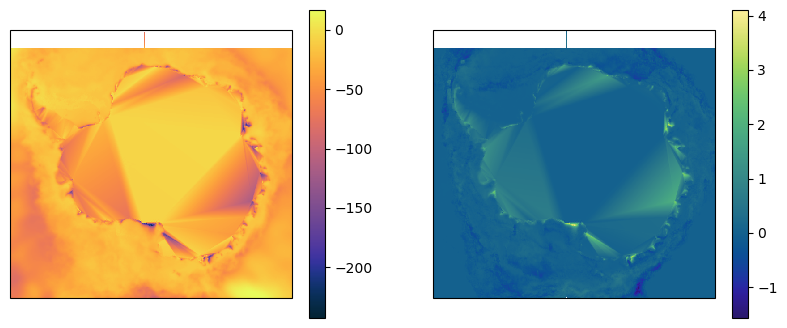

In [6]:
proj = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(122, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km, swflux.mean('swf_time'), transform=ccrs.PlateCarree(), cmap=cmocean.haline)
plt.colorbar()

ax2 = fig.add_subplot(121, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km, shflux.mean('shf_time'), transform=ccrs.PlateCarree(), cmap=cmocean.thermal)
plt.colorbar()
plt.show()


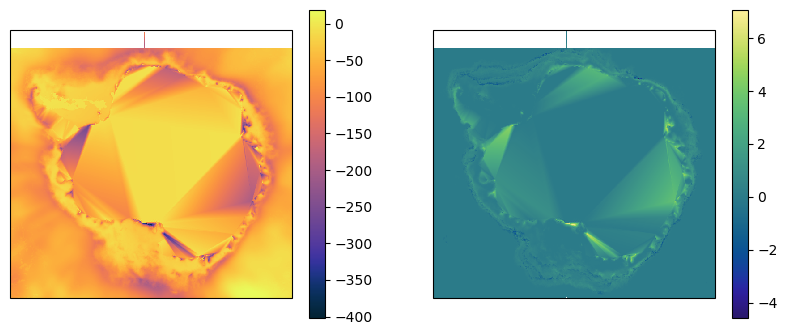

In [7]:
proj = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(122, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km, swflux.isel(swf_time=slice(90,120)).mean('swf_time'), transform=ccrs.PlateCarree(), cmap=cmocean.haline)
plt.colorbar()

ax2 = fig.add_subplot(121, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km, shflux.isel(shf_time=slice(90,120)).mean('shf_time'), transform=ccrs.PlateCarree(), cmap=cmocean.thermal)
plt.colorbar()
plt.show()

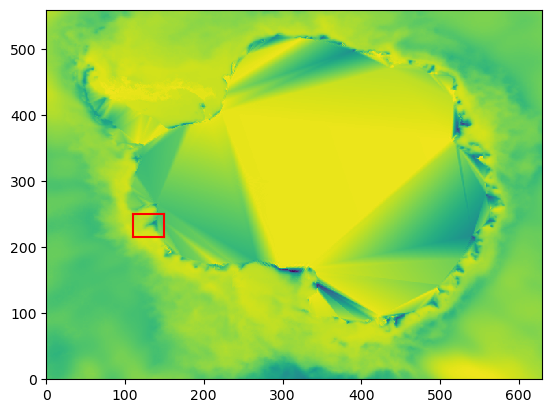

In [8]:
plt.pcolormesh(shflux.isel(shf_time=slice(80,200)).mean('shf_time'))
# square polygon: x= 110:150, y= 215:260
plt.plot([110, 150],[215, 215],'r')
plt.plot([110, 150],[250, 250],'r')
plt.plot([110, 110],[215, 250],'r')
plt.plot([150, 150],[215, 250],'r')

In [ ]:
# West Antarctica

proj = ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(122, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km, swflux.isel(swf_time=slice(90,120)).mean('swf_time'), transform=ccrs.PlateCarree(), cmap=cmocean.haline)
plt.colorbar()

ax2 = fig.add_subplot(121, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km, shflux.isel(shf_time=slice(90,120)).mean('shf_time'), transform=ccrs.PlateCarree(), cmap=cmocean.thermal)
plt.colorbar()
plt.show()

# todo:

1. determine polygon for the Amundsen Coastal Polynya
2. multiply SHFLUX and SWFLUX for 0.1 within the polynya
3. export ncdf tmp file with mod (10%) surface fluxes
4. create forcing files with modified fields


In [32]:
%%time

# create modified shflux and swflux fields:

# Initialize empty arrays:
shflux_mod = np.empty_like(shflux.values)
swflux_mod = np.empty_like(swflux.values)


# Loop over each time step, only during March to 1st November months: 60:203 time indexes
# for i in range(59,203):   #shflux.shape[0]):
#     # print(i)
# # Create the rotational matrix for the current time step
#     shflux_mod[i] = shflux[i]*0.1
#     swflux_mod[i] = swflux[i]*0.1

# square polygon: x= 110:150, y= 215:260
# t= 59:203
ts=59
te=305
xs=109
xe=150
ys=214
ye=250
shflux_mod = shflux.copy()
swflux_mod = swflux.copy()

shflux_mod[ts:te,ys:ye,xs:xe] = 0.1*shflux[ts:te,ys:ye,xs:xe]
# shflux_mod[0:ts,0:ys,0:xe] = shflux[0:ts,0:ys,0:xe]
# shflux_mod[te:-1,ye:-1,xe:-1] = shflux[te:-1,ye:-1,xe:-1]

swflux_mod[ts:te,ys:ye,xs:xe] = 0.1*swflux[ts:te,ys:ye,xs:xe]
# swflux_mod[0:ts,0:ys,0:xe] = swflux[0:ts,0:ys,0:xe]
# swflux_mod[te:-1,ye:-1,xe:-1] = swflux[te:-1,ye:-1,xe:-1]

# Convert the results back to xarray DataArrays
shflux_mod_da = xr.DataArray(shflux_mod, dims=['shf_time', 'eta_rho', 'xi_rho'])
swflux_mod_da = xr.DataArray(swflux_mod, dims=['swf_time', 'eta_rho', 'xi_rho'])


CPU times: user 531 ms, sys: 556 ms, total: 1.09 s
Wall time: 894 ms


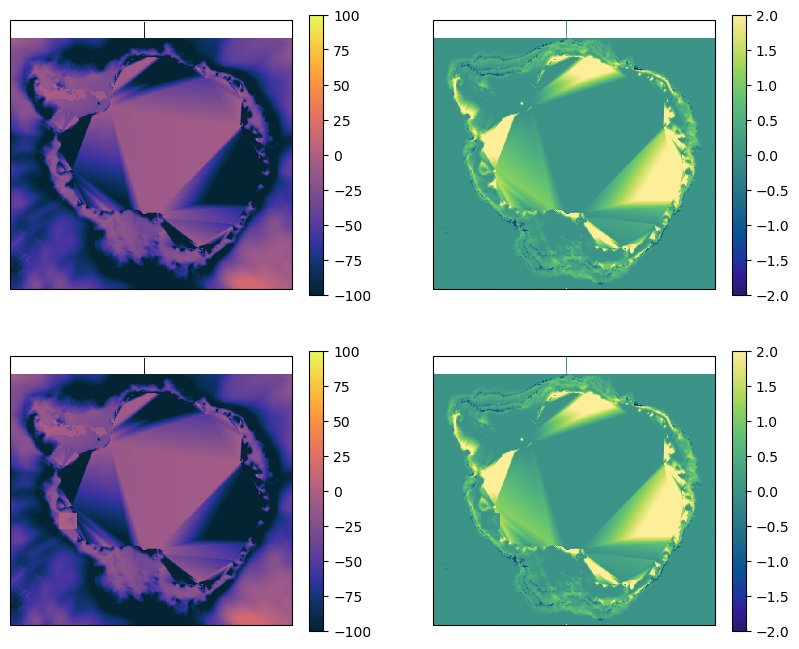

In [33]:
proj = ccrs.SouthPolarStereo()

hmin=-100
hmax=100
wmin=-2
wmax=2

fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(222, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km, swflux.isel(swf_time=slice(90,120)).mean('swf_time'), transform=ccrs.PlateCarree(), cmap=cmocean.haline, vmin=wmin, vmax=wmax)
plt.colorbar()

ax2 = fig.add_subplot(221, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km, shflux.isel(shf_time=slice(90,120)).mean('shf_time'), transform=ccrs.PlateCarree(), cmap=cmocean.thermal, vmin=hmin, vmax=hmax)
plt.colorbar()

ax3 = fig.add_subplot(224, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km, swflux_mod_da.isel(swf_time=slice(90,120)).mean('swf_time'), transform=ccrs.PlateCarree(), cmap=cmocean.haline, vmin=wmin, vmax=wmax)
plt.colorbar()

ax4 = fig.add_subplot(223, projection=proj)
plt.pcolormesh(lon_rho_10km,lat_rho_10km, shflux_mod_da.isel(shf_time=slice(90,120)).mean('shf_time'), transform=ccrs.PlateCarree(), cmap=cmocean.thermal, vmin=hmin, vmax=hmax)
plt.colorbar()

plt.show()

In [34]:
# save into netcdf file (shflux_mod_da, swflux_mod_da)

# Dataset.to_netcdf(path=None, mode='w', format=None, group=None, engine=None, encoding=None, unlimited_dims=None, compute=True, invalid_netcdf=False)

shflux_mod_da.to_netcdf(path='/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/Tamura_flux_mods/waom10_frc_tmp/waom10extend_shflux_0.25Q_modWAnt.nc', mode='w')
swflux_mod_da.to_netcdf(path='/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/Tamura_flux_mods/waom10_frc_tmp/waom10extend_swflux_modWAnt.nc', mode='w')


In [35]:
shflux_mod_da.close()
swflux_mod_da.close()